In [1]:
import os
from pathlib import Path
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from interpretable_tsne.tsne import TSNE

os.chdir('..') # hacky

In [2]:
# figure 1 plot

# path/to/results/dir
data_dir = 'data/MNIST'
data_dir_corr = '/lustre07/scratch/sciclun4/data/MNIST/interpretable_tsne'
results_dir = '/scratch/sciclun4/results/interpretable_tsne/mnist/mnist/'
run_id = 23
data_id = 0

In [3]:
def get_data(data_dir, data_id):
    data_dir = '{}/{}'.format(data_dir, data_id)
    arr_obj_orig = np.load(Path(data_dir) / 'processed_data.npz', allow_pickle=True) 
    labels = arr_obj_orig['labels']
    X_reduced = arr_obj_orig['X_reduced']
    orig_data = arr_obj_orig['X_original']
    pca_obj = arr_obj_orig['pca_obj'].item() # get loadings
    # Get the loadings from the PCA object
    loadings = pca_obj.components_ * np.sqrt(pca_obj.explained_variance_).reshape(-1, 1)

    return labels, X_reduced, orig_data, pca_obj, loadings

def get_attrs(results_dir, run_id, loadings):
    results_dir = '{}/{}'.format(results_dir, run_id)
    arr_obj_orig = np.load(Path(results_dir) / 'tsne_results_style=grad_norm.npz', allow_pickle=True)
    out = arr_obj_orig['out'].item()
    attrs = out['attrs']

    # remove numerically unstable attributions
    attrs = np.concatenate(out['attrs'])
    attrs[np.isnan(attrs)] = 0
    attrs[np.abs(attrs) == np.inf] = 0
    # only look at steps 250 and -1
    attrs = attrs[[0,250,-1]]

    lower_perc = np.percentile(attrs, 5)
    higher_perc = np.percentile(attrs, 95)
    attrs = np.clip(attrs, lower_perc, higher_perc)

    # project to input space via loadings
    attrs = np.matmul(attrs, loadings).reshape(attrs.shape[0], attrs.shape[1], 28, 28)

    return attrs

def _get_data_id_new(run_id, amount_removed, corruption_method, attr_type):
    # attribution based
    if attr_type in ['top_attr', 'attr_feat', 'top_attr_unif', 'top_attr_times_feat_unif', 'top_attr_unif_class', 'top_attr_times_feat_unif_class']:
        return '{}_{}_rem={}_step=250_method={}_style=grad_norm'.format(run_id, attr_type, amount_removed, corruption_method)
    # random baselines
    elif attr_type in ['rand', 'rand_class', 'rand_group']:
        # just use run 1.
        return '{}_{}_rem={}_run=1_step=250_method={}'.format(run_id, attr_type, amount_removed, corruption_method)
    # non-attribution baselines
    elif attr_type in ['feat_size', 'top_fs', 'top_pc', 'top_ls_p_matrix', 'top_ls_q_matrix', 'top_feat', 'top_ls_class_p_matrix', 'top_ls_class_q_matrix', 'top_feat_class']:
        return '{}_{}_rem={}_step=250_method={}'.format(run_id, attr_type, amount_removed, corruption_method)
    else:
        raise ValueError

def _get_run_id_new(run_id, attr_type, amount_removed, corruption_method, r_seed=1):
    # attribution based
    if attr_type in ['top_attr', 'attr_feat', 'top_attr_unif', 'top_attr_times_feat_unif', 'top_attr_unif_class', 'top_attr_times_feat_unif_class']:
        return '{}_{}_rem={}_step=250_method={}_style=grad_norm'.format(run_id, attr_type, amount_removed, corruption_method)
    # random baselines
    elif attr_type in ['rand', 'rand_class', 'rand_group']:
        # just use run 1.
        return '{}_{}_rem={}_run={}_step=250_method={}'.format(run_id, attr_type, amount_removed, r_seed, corruption_method)
    # non-attribution baselines
    elif attr_type in ['feat_size', 'top_fs', 'top_pc', 'top_ls_p_matrix', 'top_ls_q_matrix', 'top_feat', 'top_ls_class_p_matrix', 'top_ls_class_q_matrix', 'top_feat_class']:
        return '{}_{}_rem={}_step=250_method={}'.format(run_id, attr_type, amount_removed, corruption_method)
    else:
        raise ValueError

def get_corrupted_emb(results_dir, run_id, amount_removed, corruption_method, attr_type):
    run_id_new = _get_run_id_new(run_id, attr_type, amount_removed, corruption_method)
    results_dir = '{}/{}'.format(results_dir, run_id)
    arr_obj_perturbed = np.load(Path(results_dir) / 'tsne_results_{}.npz'.format(run_id_new), allow_pickle=True)
    out_perturbed = arr_obj_perturbed['out'].item()
    emb_pert = out_perturbed['embeddings'][-1]
    return emb_pert

def get_corrupted_data(data_dir, data_id, run_id, amount_removed, corruption_method, attr_type):
    data_dir = '{}/{}'.format(data_dir, data_id)
    data_id_new = _get_data_id_new(run_id, amount_removed, corruption_method, attr_type)

    arr_obj_file = '{}/{}_processed_data.npz'.format(data_dir, data_id_new)
    arr_obj_pert = np.load(arr_obj_file, allow_pickle=True)
    X_reduced_pert = arr_obj_pert['X_reduced']
    return X_reduced_pert

def get_embeds(results_dir, run_id):
    results_dir = '{}/{}'.format(results_dir, run_id)
    arr_obj_orig = np.load(Path(results_dir) / 'tsne_results_style=grad_norm.npz', allow_pickle=True)
    out = arr_obj_orig['out'].item()
    emb_orig = out['embeddings'][-1]
    return emb_orig

In [4]:
labels, X_reduced, orig_data, pca_obj, loadings = get_data(data_dir, data_id)
attrs = get_attrs(results_dir=results_dir, run_id=23, loadings=loadings)

# how = 'top_attr', 'feat_size', 'attr_feat'
#.      'top_fs', 'top_pc', 'top_ls', 'top_feat', 'top_attr_unif', 'top_attr_times_feat_unif'
#       'top_ls_class', 'top_attr_unif_class', 'top_feat_class', 'top_attr_times_feat_unif_class'
emb_pert = get_corrupted_emb(results_dir=results_dir, run_id=23, amount_removed=5, corruption_method='mean', attr_type='attr_feat')
X_reduced_perm = get_corrupted_data(data_dir=data_dir_corr, data_id=0, run_id=23, amount_removed=5, corruption_method='mean', attr_type='attr_feat')
emb = get_embeds(results_dir=results_dir, run_id=23)

/lustre06/project/6065672/sciclun4/Envs/test_env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator PCA from version 1.0.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


## Plot t-SNE Before and After Corruption

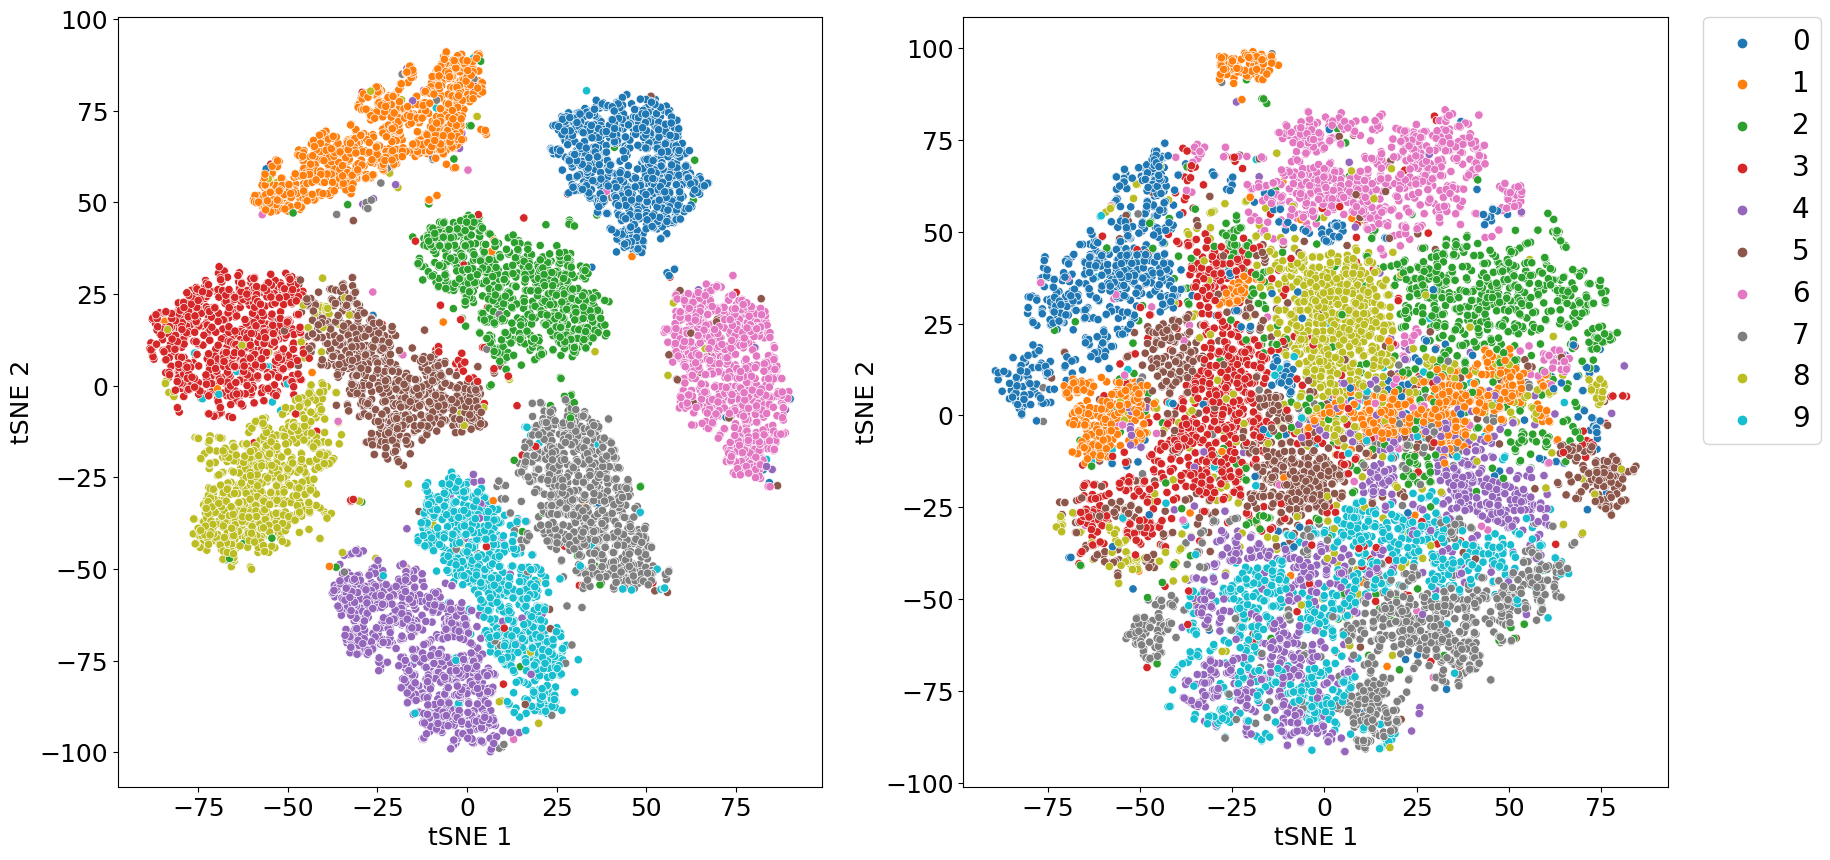

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
_ = sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=labels, ax=ax[0], hue_order=np.unique(labels), legend=False)
_ = sns.scatterplot(x=emb_pert[:,0], y=emb_pert[:,1], hue=labels, ax=ax[1], hue_order=np.unique(labels))

ax[0].tick_params(axis='both', which='major', labelsize=18)
ax[0].tick_params(axis='both', which='minor', labelsize=18)
ax[0].xaxis.label.set_fontsize(18)
ax[0].yaxis.label.set_fontsize(18)
ax[0].set_xlabel('tSNE 1')
ax[0].set_ylabel('tSNE 2')
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].tick_params(axis='both', which='minor', labelsize=18)
ax[1].xaxis.label.set_fontsize(18)
ax[1].yaxis.label.set_fontsize(18)
ax[1].set_xlabel('tSNE 1')
ax[1].set_ylabel('tSNE 2')
_ = plt.legend(prop={'size': 20}, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

##  Plot Digit Before and After Corruption, With Attribution

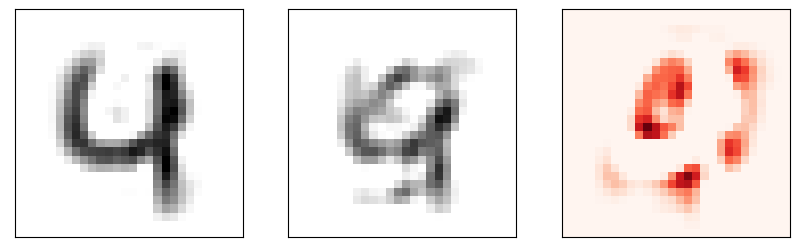

In [6]:
r_id = 6819

digit_orig_recon = pca_obj.inverse_transform(X_reduced[r_id]).reshape(28, 28)
digit_corrupted_recon = pca_obj.inverse_transform(X_reduced_perm[r_id]).reshape(28, 28)
attr_recon = attrs[1][r_id].reshape(28, 28)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

#vmax = max(digit_orig_recon.max(), digit_corrupted_recon.max(), attr_recon.max())
#vmin = min(digit_orig_recon.min(), digit_corrupted_recon.min(), attr_recon.min())

_ = ax[0].imshow(digit_orig_recon, cmap='gray_r', vmin=np.percentile(digit_orig_recon, 70), vmax=digit_orig_recon.max())
_ = ax[1].imshow(digit_corrupted_recon, cmap='gray_r', vmin=np.percentile(digit_corrupted_recon, 70), vmax=digit_orig_recon.max())
_ = ax[2].imshow(attr_recon, cmap='Reds', vmin=np.percentile(attr_recon, 70), vmax=attr_recon.max())

for i in range(3):
    _ = ax[i].set_xticklabels([])
    _ = ax[i].set_yticklabels([])
    _ = ax[i].set_xticks([])
    _ = ax[i].set_yticks([])

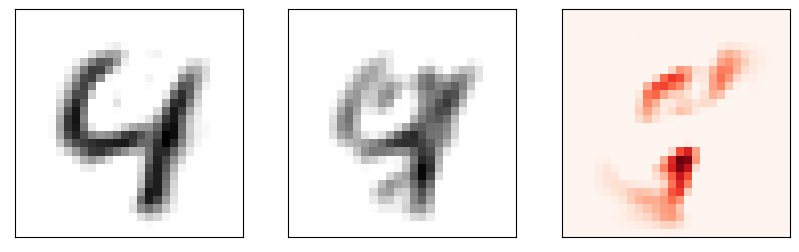

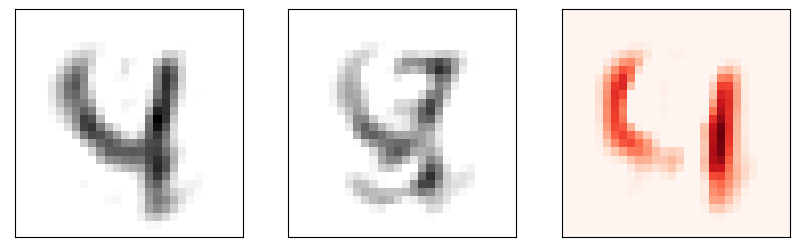

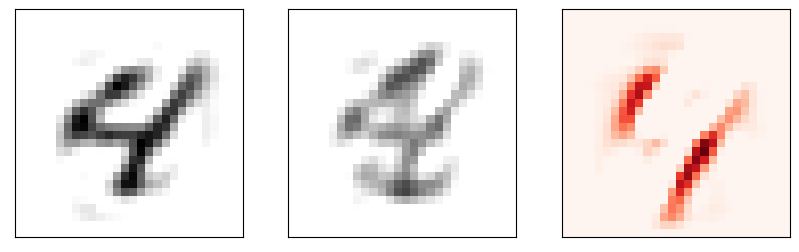

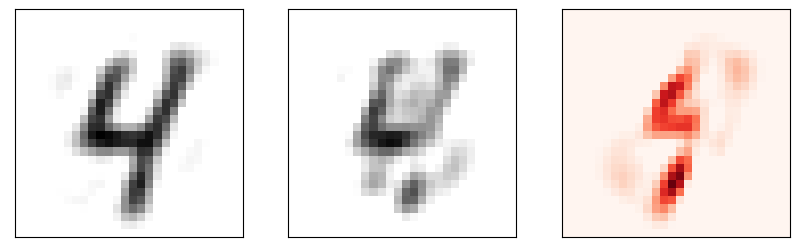

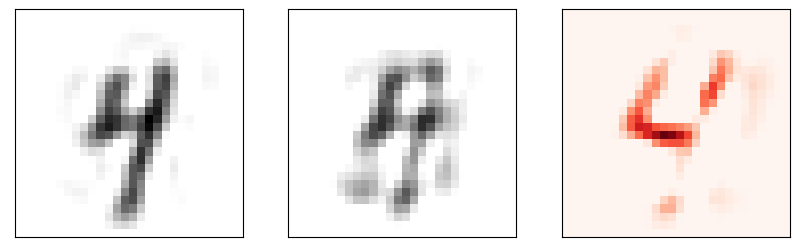

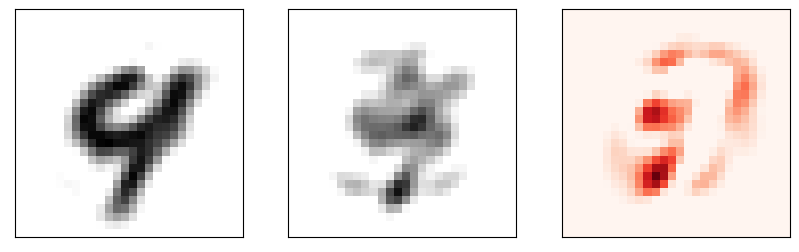

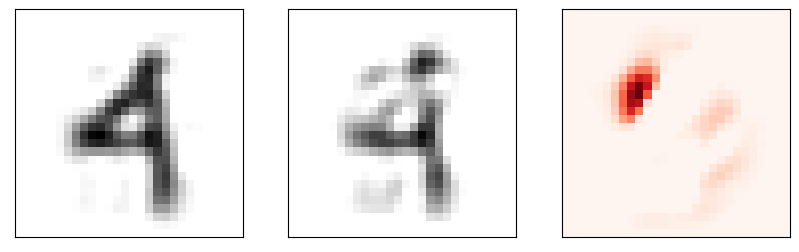

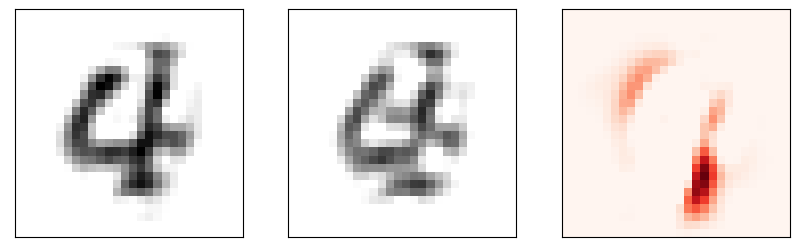

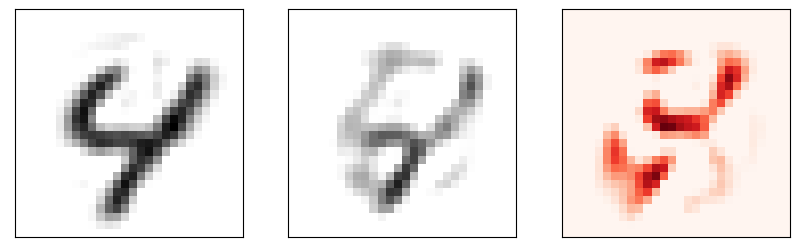

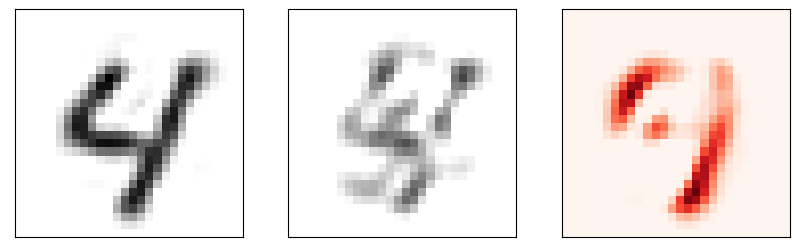

In [7]:
for i in range(10):
    r_id = np.random.choice(np.arange(10000)[labels == '4'])
    digit_orig_recon = pca_obj.inverse_transform(X_reduced[r_id]).reshape(28, 28)
    digit_corrupted_recon = pca_obj.inverse_transform(X_reduced_perm[r_id]).reshape(28, 28)
    attr_recon = attrs[1][r_id].reshape(28, 28)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))

    #vmax = max(digit_orig_recon.max(), digit_corrupted_recon.max(), attr_recon.max())
    #vmin = min(digit_orig_recon.min(), digit_corrupted_recon.min(), attr_recon.min())

    _ = ax[0].imshow(digit_orig_recon, cmap='gray_r', vmin=np.percentile(digit_orig_recon, 70), vmax=digit_orig_recon.max())
    _ = ax[1].imshow(digit_corrupted_recon, cmap='gray_r', vmin=np.percentile(digit_corrupted_recon, 70), vmax=digit_orig_recon.max())
    _ = ax[2].imshow(attr_recon, cmap='Reds', vmin=np.percentile(attr_recon, 70), vmax=attr_recon.max())

    for i in range(3):
        _ = ax[i].set_xticklabels([])
        _ = ax[i].set_yticklabels([])
        _ = ax[i].set_xticks([])
        _ = ax[i].set_yticks([])

## Look at Class-Averaged Attributions

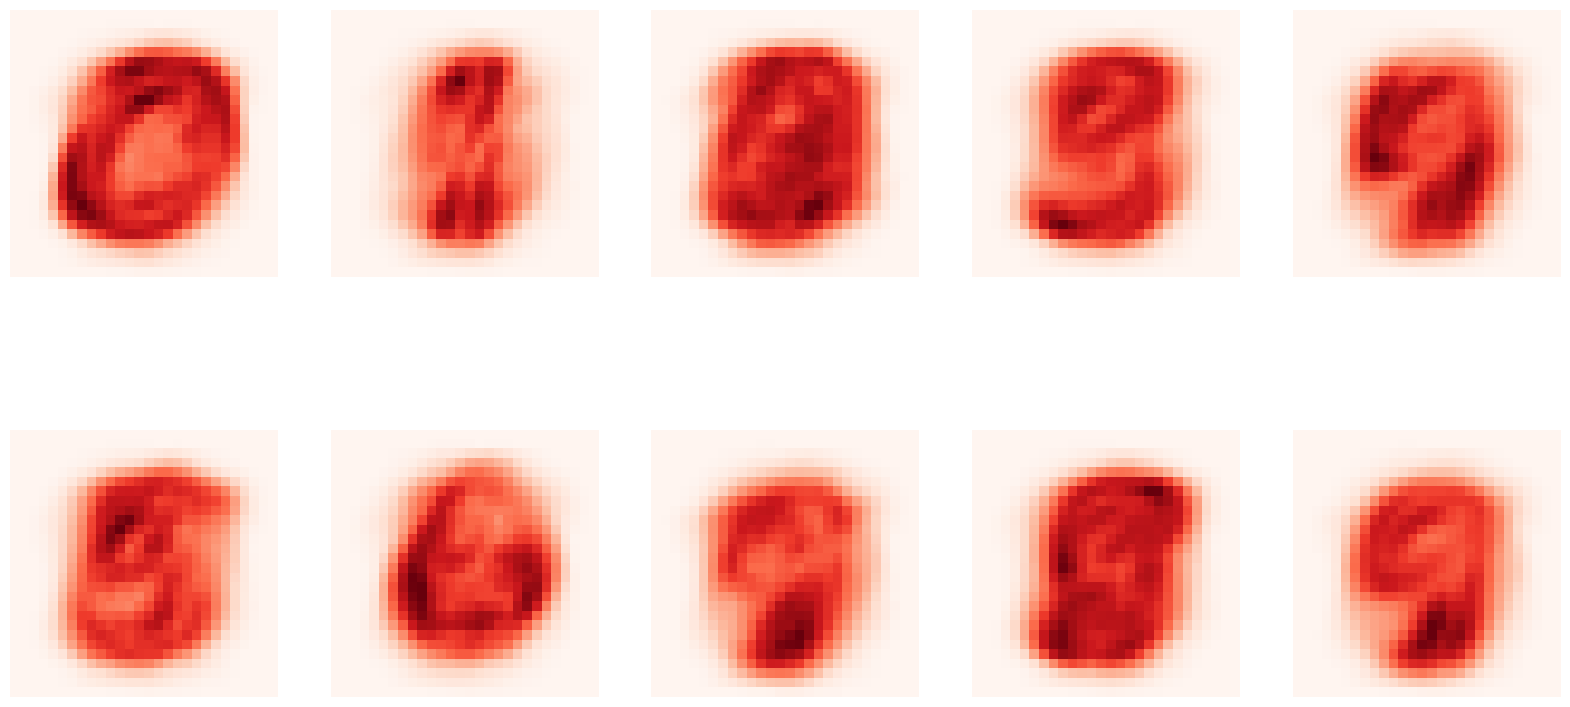

In [9]:
attr_to_plot = 0
unique_labels = np.unique(labels)

fig, ax = plt.subplots(2, 5, figsize=(20, 10))

k = 0
for i in range(2):
    for j in range(5):
        indices_to_merge = (labels == unique_labels[k])
        _attr = np.abs(attrs[1][indices_to_merge])

        img = _attr.mean(0)
        #img = remove_min_max_attrs(img, 25, 100)

        #max_val = np.abs(img).max()
        vmin= np.percentile(img, 0)
        ax[i,j].imshow(img, 
                       alpha=1, 
                       cmap='Reds', 
                       vmin=vmin, 
                       vmax=img.max(), 
                       interpolation='nearest')
        k += 1
        ax[i,j].axis('off')

## Display Corruption Continuum

In [11]:
X_reduced_perms = []
for amount_removed in [1, 3, 5, 7, 9]:
    X_reduced_perms.append(get_corrupted_data(data_dir=data_dir_corr, data_id=0, run_id=23, amount_removed=amount_removed, corruption_method='mean', attr_type='attr_feat'))

In [14]:
def make_comparison_plots(r_ids, X_reduced, X_reduced_perms):
    fig, ax = plt.subplots(nrows=len(r_ids), ncols=len(X_reduced_perms)+1, figsize=(15, 5))
    for j, r_id in enumerate(r_ids):
        digit_orig_recon = pca_obj.inverse_transform(X_reduced[r_id]).reshape(28, 28)
        _ = ax[j,0].imshow(digit_orig_recon, cmap='gray_r', vmin=np.percentile(digit_orig_recon, 50), vmax=digit_orig_recon.max())
        _ = ax[j,0].set_xticklabels([])
        _ = ax[j,0].set_yticklabels([])
        _ = ax[j,0].set_xticks([])
        _ = ax[j,0].set_yticks([])
        for i, X_reduced_perm in enumerate(X_reduced_perms):
            digit_corrupted_recon = pca_obj.inverse_transform(X_reduced_perm[r_id]).reshape(28, 28)
            _ = ax[j,i+1].imshow(digit_corrupted_recon, cmap='gray_r', vmin=np.percentile(digit_corrupted_recon, 50), vmax=digit_corrupted_recon.max())
            _ = ax[j,i+1].set_xticklabels([])
            _ = ax[j,i+1].set_yticklabels([])
            _ = ax[j,i+1].set_xticks([])
            _ = ax[j,i+1].set_yticks([])

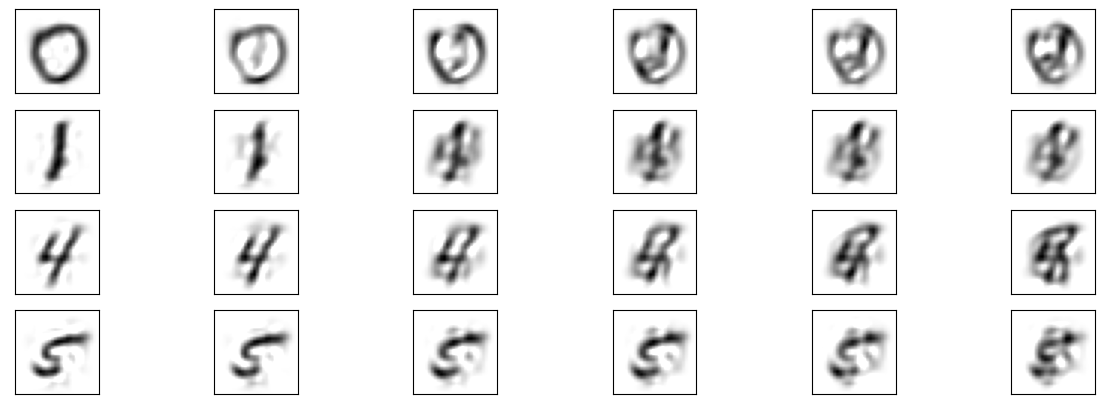

In [15]:
make_comparison_plots([3188, 2392, 6875, 81], X_reduced, X_reduced_perms)

## Look At Attributions in a Given Neighborhood